In [2]:
import os
import numpy as np
import seaborn as sns
from praatio import tgio
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import chisquare
import time


# %matplotlib qt

def fillDB_syntAndGpt2(datainp, dataSpacy, dataGpt2, durationList, dataProm, a, mask, speakNN, idxf, cntf, cnt2f):
    # Filling the data
    datainp['Word'].append(dataSpacy[idxf][0].lower())
    datainp['PoS'].append(dataSpacy[idxf][1])

    datainp['TypeOfDep'].append(dataSpacy[idxf][7])

    cont_flag = 0
    if dataSpacy[idxf][1] == 'NOUN':
        datainp['PoSClass'].append(1)
        cont_flag = 1
    elif dataSpacy[idxf][1] == 'VERB':
        datainp['PoSClass'].append(2)
        cont_flag = 1
    elif dataSpacy[idxf][1] == 'ADP':
        datainp['PoSClass'].append(3)
    elif dataSpacy[idxf][1] == 'DET':
        datainp['PoSClass'].append(4)
    elif dataSpacy[idxf][1] == 'PRON':
        datainp['PoSClass'].append(5)
    elif dataSpacy[idxf][1] == 'ADJ':
        datainp['PoSClass'].append(6)
        cont_flag = 1
    elif dataSpacy[idxf][1] == 'ADV':
        datainp['PoSClass'].append(7)
        cont_flag = 1
    else:
        datainp['PoSClass'].append(0)

    datainp['ContentW'].append(cont_flag)
    # if dataSpacy[i][3]>0: # if more than 3 merge
    #     datainp['LeftNumber'].append(1)
    # else:
    #     datainp['LeftNumber'].append(0)

    datainp['LeftNumber'].append(dataSpacy[idxf][8])
    datainp['Pos2End'].append(dataSpacy[idxf][9])

    if dataSpacy[idxf][2] >= 3:  # if more than 3 merge
        datainp['NodeRight'].append(3)
    else:
        datainp['NodeRight'].append(dataSpacy[idxf][2])
    if dataSpacy[idxf][3] >= 3:
        datainp['NodeLeft'].append(3)
    else:
        datainp['NodeLeft'].append(dataSpacy[idxf][3])
    # adding arc info and type of the sentence
    datainp['ArcLen'].append(dataSpacy[idxf][4])
    datainp['negationFlag'].append(dataSpacy[idxf][6])

    if dataSpacy[i][5] == 1:
        datainp['TypeSent'].append('interr')
    else:
        datainp['TypeSent'].append('decl')

    # add gpt2 information (PoS entropy)
    datainp['Entropy'].append(dataGpt2['Ent'][cnt2f])
    datainp['Start'].append(durationList[cntf][0])
    datainp['Stop'].append(durationList[cntf][1])

    datainp['ProsodyProm'].append(dataProm[cntf][0])
    datainp['ProsodyBound'].append(dataProm[cntf][1])

    # add pitch info
    datainp['pitchMedian'].append(np.median(a[mask, 1]) / medA)
    datainp['pitchMean'].append(np.mean(a[mask, 1]) / medA)
    datainp['speak'].append(speakNN)
    model = LinearRegression().fit(a[mask, 0].reshape((-1, 1)), a[mask, 1])
    datainp['pitchSlope'].append(model.coef_[0])

    return datainp


In [3]:
speakerList = ['DanielKahneman', 'JamesCameron', 'JaneMcGonigal', 'TomWujec']
path = '/home/deganog21/Projects/WP_Prosody'
# init the features
IntiDataFrame_syntax = {'Word': [], 'PoS': [], 'PoSClass': [], 'ContentW': [], 'Entropy': [], 'LeftNumber': [],
                        'Pos2End': [], 'ProsodyProm': [], 'ProsodyBound': [], 'NodeRight': [], 'NodeLeft': [],
                        'TypeOfDep': [], 'ArcLen': [], 'TypeSent': [], 'negationFlag': [],
                        'Start': [], 'Stop': [], 'pitchMedian': [], 'pitchMean': [], 'pitchSlope': [], 'speak': []}
dfPitch = pd.DataFrame({'pitch': [], 'speak': []})
medianPitch = []

cnt_or = 1
df_full = pd.DataFrame(data=IntiDataFrame_syntax)

for name in speakerList:
    timeN = time.time()
    a = np.load(os.path.join(path, 'AlignedTeds', name + 'Pitch.npy'))
    # cutting aout the first seconds...
    cut = 300
    speakNN = ['sp' + str(cnt_or)] * len(a[cut:, 1])
    df2 = pd.DataFrame({'pitch': a[cut:, 1], 'speak': speakNN})
    medA = np.median(a[cut:, 1])
    medianPitch.append(medA)

    # g = sns.relplot(x="time", y="pitch", kind="line", data=df)
    # g.fig.autofmt_xdate()
    dfPitch = dfPitch.append(df2, ignore_index=True)
    cnt_or = cnt_or + 1

    # load forced aligned data
    inputFN = os.path.join(path, 'AlignedTeds', name + '_2010_GD.TextGrid')
    tg = tgio.openTextgrid(inputFN)

    entryList = tg.tierDict["words"].entryList
    wordTier = tg.tierDict['words']

    # I just want the labels from the entryList
    labelList = [entry[2] for entry in wordTier.entryList]
    # Get the duration of each interval
    # (in this example, an interval is a word, so this outputs word duration)
    durationList = []
    for start, stop, _ in wordTier.entryList:
        durationList.append([start, stop])

    # load prominance data
    f = open(os.path.join(path, 'ProminanceDetection', name + '_2010.prom'), 'r')
    lines = f.readlines()
    dataProm = []
    for x in lines:
        dataProm.append([float(x.split()[4]), float(x.split()[5])])
    f.close()

    # load dependencies
    with open(os.path.join(path, 'AlignedTeds', name + '_Spacy2tags_reduce_2010.txt')) as json_file:
        dataSpacy = json.load(json_file)

    dataGpt2 = pd.read_pickle(os.path.join(path, 'AlignedTeds', name + '_gpt2_ent.pkl'))

    list2roll = dataGpt2['Ent'].tolist()
    # shifting by one the list... need to be the lock on the word not on the previuos prediction
    from scipy import stats

    firstEnt = stats.entropy(1 / 18 * np.ones(18))
    list2roll.insert(0, firstEnt)
    list2roll.pop(-1)

    dataGpt2['Ent'] = list2roll

    # correcting mistakes
    if name == 'DanielKahneman':
        idx = 780
        dataSpacy[idx][0] = 'B'

    if name == 'JaneMcGonigal':
        idx = 2
        labelList[idx] = 'mcgonigal'

        idx = 1416
        labelList.insert(idx, '\'s')
        durationList.insert(idx, [durationList[idx - 1][1], durationList[idx + 1][0]])
        dataProm.insert(idx, [dataProm[idx - 1][0], dataProm[idx - 1][1]])

        idx = 1411
        dataSpacy[idx][0] = '10080'

        idx = 3503
        dataSpacy[idx][0] = '8000'

    if name == 'TomWujec':
        idx = 407
        dataSpacy[idx][0] = 'inc'

        idx = 999
        dataSpacy[idx][0] = 'marshmallowchallengecom'

    # % Merging aligner, spacy and gtp2 data

    cnt = 0
    cnt2 = 0
    flagSkip = 0

    dataxx = {'Word': [], 'PoS': [], 'PoSClass': [], 'Entropy': [], 'ContentW': [], 'ProsodyProm': [], 'Pos2End': [],
              'LeftNumber': [], 'ProsodyBound': [], 'NodeRight': [], 'NodeLeft': [], 'TypeOfDep': [], 'ArcLen': [],
              'TypeSent': [], 'negationFlag': [],
              'Start': [], 'Stop': [], 'pitchMedian': [], 'pitchMean': [], 'pitchSlope': [], 'speak': []}
    print(len(dataSpacy))

    for i in range(len(dataSpacy)):

        # IMPORTANT!!!! flag to deal with the splitting tokens (she's = she + 's). I am removing it to avoid issus with incorrect timing
        if flagSkip == 1:
            flagSkip = 0
            cnt2 += 1
            continue
        flag = 1
        flagSpace = (dataSpacy[i][1] != 'SPACE' and dataSpacy[i][0] != '--')
        # flag to deal with skipping word because of out of dic in aligner ('unk').. goes for a search in the next 10 tokens
        flg50 = 0
        # counter of the aligner
        cntOrig = cnt
        # counter for the gpt2
        cntOrig2 = cnt2
        # if flagSpace:
        #      print(dataSpacy[i][0].lower(),labelList[cnt].lower(),dataGpt2['Word'][cnt2].lower())
        #      print(i,cnt,cnt2)
        while (flag and flagSpace):
            # remove further punctuation (not of interest)
            if dataGpt2['Word'][cnt2] == '' or dataGpt2['Word'][cnt2] == '--' or dataGpt2['Word'][cnt2] == '"' or \
                    dataGpt2['Word'][cnt2] == '\n':
                cnt2 += 1
            # check comparison between gpt2 and spacy
            if dataSpacy[i][0].lower() == dataGpt2['Word'][cnt2].lower():
                if dataSpacy[i][0].lower() == labelList[cnt].lower():
                    flag = 0
                    mask = (a[:, 0] < durationList[cnt][1]) & (a[:, 0] > durationList[cnt][0])
                    if np.any(mask):
                        fillDB_syntAndGpt2(dataxx, dataSpacy, dataGpt2, durationList, dataProm, a, mask, speakNN, i,
                                           cnt, cnt2)
                        # print(dataSpacy[i][0].lower(),labelList[cnt].lower(),dataGpt2['Word'][cnt2].lower())
                    cnt += 1
                    cnt2 += 1
                # check if the missign congruency is because of splitted token (she's = she + 's)
                elif dataSpacy[i][0].lower() + dataSpacy[i + 1][0].lower() == labelList[cnt].lower():
                    flag = 0
                    cnt += 1
                    cnt2 += 1
                    flagSkip = 1
                # IMPORTANT!!! if aligner did not recognize the word ('unk') I am removing it
                elif (flg50 == 10 and labelList[cntOrig].lower() == '<unk>'):
                    flag = 0

                    mask = (a[:, 0] < durationList[cnt][1]) & (a[:, 0] > durationList[cnt][0])
                    if np.any(mask):
                        fillDB_syntAndGpt2(dataxx, dataSpacy, dataGpt2, durationList, dataProm, a, mask, speakNN, i,
                                           cnt, cnt2)

                    cnt = cntOrig + 1
                    cnt2 = cntOrig2 + 1

                else:
                    cnt += 1
                    flg50 += 1
            else:
                cnt2 += 1

    # add the speaker data to the dataframe            
    df_temp = pd.DataFrame(data=dataxx)
    print(df_temp.shape)

    print(df_temp['Start'][0])
    df_full = df_full.append(df_temp, ignore_index=True)
    print(name + ' ' + str(time.time() - timeN))

    your_keys = ['Entropy', 'NodeLeft', 'NodeRight', 'Start', 'Stop', 'LeftNumber', 'ContentW', 'pitchMean', 'PoSClass',
                 'ProsodyProm', 'ProsodyBound', 'TypeOfDep', 'Pos2End']
    datatoSave = {your_key: dataxx[your_key] for your_key in your_keys}

    del dataxx

    # a_file = open(os.path.join(path,'AlignedTeds',name+'_2010_fulldb_reduce.json'), "w")
    # json.dump(datatoSave, a_file, indent=4)
    # a_file.close()


/tmp/ipykernel_3950013/3137138902.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPitch = dfPitch.append(df2, ignore_index=True)


2680
(2550, 21)
15.923500375003124
DanielKahneman 3.241349697113037


/tmp/ipykernel_3950013/3137138902.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df_temp, ignore_index=True)
/tmp/ipykernel_3950013/3137138902.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPitch = dfPitch.append(df2, ignore_index=True)


2865
(2690, 21)
17.180014769845183
JamesCameron 3.188497304916382


/tmp/ipykernel_3950013/3137138902.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df_temp, ignore_index=True)
/tmp/ipykernel_3950013/3137138902.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPitch = dfPitch.append(df2, ignore_index=True)


3851
(3547, 21)
15.668947586275413
JaneMcGonigal 4.3488664627075195
1134


/tmp/ipykernel_3950013/3137138902.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df_temp, ignore_index=True)
/tmp/ipykernel_3950013/3137138902.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPitch = dfPitch.append(df2, ignore_index=True)


(1064, 21)
16.369057816146746
TomWujec 0.9003493785858154


/tmp/ipykernel_3950013/3137138902.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full = df_full.append(df_temp, ignore_index=True)


In [4]:
# %% Plotting
print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
print('Plots and stats')
print(len(pd.unique(df_full['Word'])))

# sns.catplot(x="LeftNumber", y="ProsodyBound", kind="violin", data=df_full)

# sns.set(font_scale = 2)

# sns.displot(df_full, x="ProsodyBound", hue="LeftNumber",kind="kde",common_norm=False,palette=("PuOr"))

# sns.displot(df_full.query('Pos2End<0 & ProsodyBound>0'),hue='LeftNumber', x="ProsodyBound", kind="kde",palette=("PuOr"))
# plt.savefig(path+'/images/distribution.svg', format='svg')

df_full['Duration']= df_full['Stop']-df_full['Start']
df_full['DurationS']= df_full['Duration'].shift(periods=-1)
subset_df = df_full.query('Pos2End<0 and ProsodyBound>0 and DurationS>.1')

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Plots and stats
1723


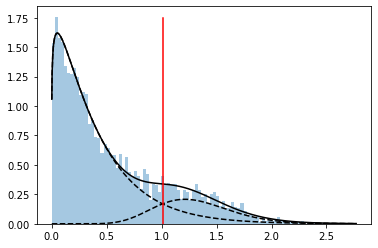

1.009924924924925


In [5]:
# %% Gamma mixture
from pomegranate import *

X = subset_df['ProsodyBound'].to_numpy().reshape(-1, 1)

num_dist = 2
model = GeneralMixtureModel.from_samples([GammaDistribution, GammaDistribution], 
                                         n_components=2,max_kmeans_iterations=10, stop_threshold=.01, X=X)

x = np.linspace(min(X), max(X), 1000)
logprob = model.log_probability(x.reshape(-1, 1))
responsibilities = model.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

yhat = model.predict(x.reshape(-1, 1))
decision = max([x[np.argwhere(yhat == 0)[0]][0][0], x[np.argwhere(yhat == 1)[0]][0][0]])

(n, bins, patches)=plt.hist(X, 100,density=True, histtype='stepfilled', alpha=0.4)
plt.plot(x, pdf, '-k')
plt.plot(x, pdf_individual, '--k')
plt.plot([decision,decision], [0, 1.75], 'r')
plt.show()


print(decision)

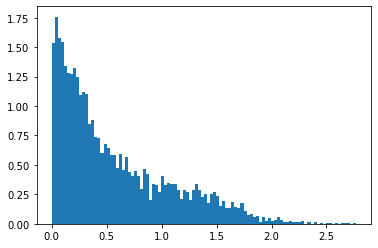

In [10]:

n=100
xt = np.linspace(min(X), max(X), n)
RSS=np.zeros((5,))
BIC=np.zeros((5,))
AIC=np.zeros((5,))
listGamma=[GammaDistribution,GammaDistribution]
(nnn, bins, patches)=plt.hist(X, n, density=True)

for num_dist in range(2,6):
    model = GeneralMixtureModel.from_samples(listGamma, 
                                             n_components=2,max_kmeans_iterations=10, stop_threshold=.01, X=X)
    logprob = model.log_probability(xt.reshape(-1, 1))
    
    pdf = np.exp(logprob)
    resid=np.subtract(pdf, nnn)
    RSS[num_dist-1] = np.sum(np.power(resid, 2))
    AIC[num_dist-1] = n * np.log(RSS[num_dist-1] / n) + 2 * num_dist*2
    
    listGamma.append(GammaDistribution)

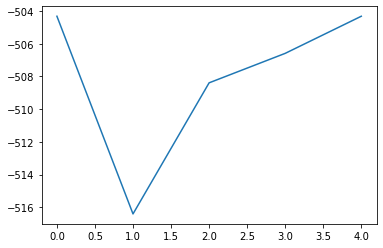

In [9]:

modelgg=GammaDistribution.from_samples(X)
pdfgg = np.exp(logprob)
logprob = model.log_probability(xt.reshape(-1, 1))
residgg=np.subtract(pdfgg, nnn)
RSS[0]= np.sum(np.power(resid, 2))
AIC[0] = n * np.log(RSS[0] / n) + 2 * num_dist*2


plt.plot(range(5),AIC)
plt.show()



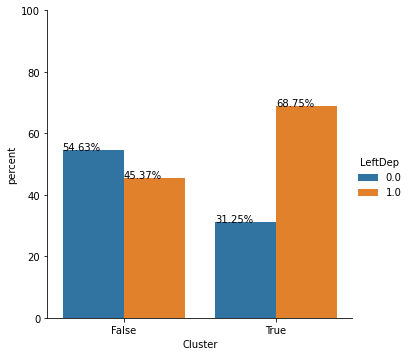

In [6]:
# %%

from statsmodels.stats.proportion import proportions_ztest

XNoLeft = subset_df.query('LeftNumber==0')['ProsodyBound'].to_numpy()
XLeft = subset_df.query('LeftNumber==1')['ProsodyBound'].sample(n=len(XNoLeft), random_state=0).to_numpy()

dd = {'ProsodyBound': np.concatenate((XNoLeft, XLeft)),
      'LeftDep': np.concatenate((np.zeros((len(XNoLeft),)), np.ones((len(XNoLeft),)))),
      'Cluster': np.concatenate((XNoLeft > decision, XLeft > decision))}

boxPlotRes = pd.DataFrame(dd)

x, y = 'Cluster', 'LeftDep'
df1 = boxPlotRes.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x, y='percent', hue=y, kind='bar', data=df1)
g.ax.set_ylim(0, 100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x, txt_y, txt)

plt.show()

In [42]:
print('%%%%%% chisquared')

group1_chi = boxPlotRes.query('Cluster==True')['LeftDep'].to_numpy()
print([sum(group1_chi == 0), sum(group1_chi == 1)])
print(chisquare([sum(group1_chi == 0), sum(group1_chi == 1)]))

group2_chi = boxPlotRes.query('Cluster==False')['LeftDep'].to_numpy()
print([sum(group2_chi == 0), sum(group2_chi == 1)])
print(chisquare([sum(group2_chi == 0), sum(group2_chi == 1)]))

print('High cluster count {0:0.0f}'.format(len(group1_chi)))
print('Low cluster count {0:0.0f}'.format(len(group2_chi)))

perc_diff=0.05
power=.8
print(' ')
print('%%% Group 1 low stat')
delta=np.sqrt(len(group2_chi))*perc_diff
nonCPar=2*delta**2/.5
print('delta low {0:0.3f}'.format(delta))
print('meanNorm low {0:0.3f}'.format(nonCPar+1))
print('stdNorm low {0:0.3f}'.format(np.sqrt(2*(1+2*nonCPar))))
print('non central low param {0:0.3f}'.format(nonCPar))

delta=np.sqrt(len(group1_chi))*perc_diff
nonCPar=2*delta**2/.5
print(' ')
print('%%% Group 2 high stat')
print('delta high {0:0.3f}'.format(delta))
print('meanNorm high {0:0.3f}'.format(nonCPar+1))
print('stdNorm high {0:0.3f}'.format(np.sqrt(2*(1+2*nonCPar))))
print('non central high param {0:0.3f}'.format(nonCPar))

print(' ')
print('From https://keisan.casio.com/menu/system/000000000540')
print('p low = 6.233 E-14')
print('p high = 2.786 E-5')


%%%%%% chisquared
[340, 748]
Power_divergenceResult(statistic=153.0, pvalue=3.83065381956498e-35)
[2407, 1999]
Power_divergenceResult(statistic=37.781207444394006, pvalue=7.914049136487386e-10)
High cluster count 1088
Low cluster count 4406
 
%%% Group 1 low stat
delta low 3.319
meanNorm low 45.060
stdNorm low 13.351
non central low param 44.060
 
%%% Group 2 high stat
delta high 1.649
meanNorm high 11.880
stdNorm high 6.747
non central high param 10.880
 
From https://keisan.casio.com/menu/system/000000000540
p low = 6.233 E-14
p high = 2.786 E-5


In [15]:
print('%%%%%% ztest')

count = np.array([sum(group1_chi == 0), sum(group2_chi == 0)])
nobs = np.array([len(group1_chi), len(group2_chi)])

stat, pval = proportions_ztest(count[0], nobs[0],value=.5)
print('{0:0.5f}'.format(pval))

stat, pval = proportions_ztest(count[1], nobs[1],value=.5)
print('{0:0.5f}'.format(pval))

%%%%%% ztest
0.00000
0.00000


In [19]:
from scipy.stats import fisher_exact

table = np.array([[sum(group1_chi == 0), sum(group2_chi == 0)], [sum(group1_chi == 1), sum(group2_chi == 1)]])
oddsr, p = fisher_exact(table, alternative='two-sided')
oddsr,p

(0.3774974506175171, 5.085589108660342e-44)